In [317]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.pair_simulator import PairSimulator
from utils.pair_zernike_estimator import PairZernikeEstimator
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth

In [318]:
donut_radius = 62  # pixels
obscuration = 0.61  # fractional
donut_area = np.pi * donut_radius**2 * (1 - obscuration**2)

pixel_scale = 0.2

In [ ]:
df = pd.read_pickle("data/test_dataframe.pkl")
df = df[df["corner"] == "R00"]

In [50]:
simulator = PairSimulator(seed=42, stamp_size=160, atm=False)

In [4]:
estimator = PairZernikeEstimator(stamp_size=160)

In [5]:
flux = 1e6

snrs = []
zk_true = []
zk_ml = []
zk_exp = []

for i in range(200):
    rng = np.random.default_rng(i)

    snr = rng.uniform(10, 600)
    noise = flux / snr
    background = np.sqrt((noise**2 - flux) / donut_area)

    simulator.set_dof(rng.choice(df["dof"]))

    pair = simulator.simulate(
        intra_flux=int(flux),
        extra_flux=int(flux),
        background=background,
    )

    snrs.append(snr)
    zk_true.append(pair.wf_dev)
    zk_ml.append(estimator.estimate(pair, "ml"))
    zk_exp.append(estimator.estimate(pair, "exp"))


snrs = np.array(snrs)
zk_true = np.array(zk_true)
zk_ml = np.array(zk_ml)
zk_exp = np.array(zk_exp)

In [12]:
np.savez("data/snr_data.npz", snrs=snrs, zk_true=zk_true, zk_ml=zk_ml, zk_exp=zk_exp)

In [319]:
zk = np.load("data/snr_data.npz")
snrs = zk["snrs"]
zk_true = zk["zk_true"]
zk_ml = zk["zk_ml"]
zk_exp = zk["zk_exp"]

In [320]:
err_ml = np.sqrt(np.sum(np.square(convertZernikesToPsfWidth(zk_ml - zk_true)), axis=1))
err_exp = np.sqrt(
    np.sum(np.square(convertZernikesToPsfWidth(zk_exp - zk_true)), axis=1)
)

In [321]:
bin_snr = np.arange(0, 600, 40)
bin_err_ml = []
bin_err_exp = []
for i in range(bin_snr.size - 1):
    bin_err_ml.append(
        np.median(err_ml[(bin_snr[i] <= snrs) & (snrs <= bin_snr[i + 1])])
    )
    bin_err_exp.append(
        np.median(err_exp[(bin_snr[i] <= snrs) & (snrs <= bin_snr[i + 1])])
    )

bin_err_ml = np.array(bin_err_ml)
bin_err_exp = np.array(bin_err_exp)

In [339]:
def mag_to_snr(mag, sky=21.20):
    mag_pixel = mag + 2.5 * np.log10(donut_area)
    sky_pixel = sky - 2.5 * np.log10(pixel_scale**2)
    snr_pixel = 10 ** ((mag_pixel - sky_pixel) / (-2.5))
    snr_tot = snr_pixel * np.sqrt(donut_area)
    return snr_tot

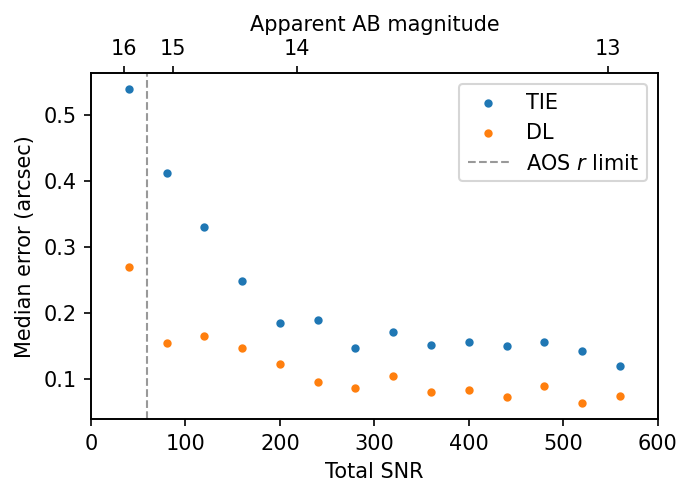

In [385]:
fig, ax = plt.subplots(figsize=(4.5, 3.2), dpi=150, constrained_layout=True)
ax2 = ax.twiny()

ax.scatter(bin_snr[1:], bin_err_exp, marker=".", label="TIE")
ax.scatter(bin_snr[1:], bin_err_ml, marker=".", label="DL")

# r band limit from AOS
rlim = 15.42
ax.axvline(mag_to_snr(rlim), c="gray", alpha=0.8, ls="--", lw=1, label="AOS $r$ limit")

ax.legend()

ax.set(xlabel="Total SNR", ylabel="Median error (arcsec)", xlim=(0, 600))

mags = [13, 14, 15, 16]
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(mag_to_snr(mags))
ax2.set_xticklabels(mags)
ax2.set(xlabel="Apparent AB magnitude")


fig.savefig("figures/snr.pdf")

plt.show()